# Making Random Starting points (Julia)

`2026.22.July.20`

My written variable reduction boundary function won't work with the example layout supplied. I'll need to make some random starts that pre-allocate turbines along the boundary, and randomly start the remaning turbines in the interior of each region. I'll use the region turbine divisions I've used before, but I'll have to be careful about how many I place on each boundary. I'll need to use these random starts in an optimization.

In [4]:
#=== Set everything up for FlowFarm ===#
cd("/Users/nbaker/Documents/GitHub/FlowFarm.jl/test/")
include("iea37_specific_functions.jl")
include("example_opt_4_ieacs4_bvr_ipm.jl")
include("../src/optimization_functions.jl")
include("../src/utilities.jl")
include("../src/io.jl")
include("../../FLOWMath.jl/src/interpolate.jl")
using FlowFarm; const ff = FlowFarm
import YAML
using PyPlot
using CSV
using Random

#--- Read in windfarm boundary data ---#
# Which case study we're doing. 'cs3' or 'cs4'
str_case = "4"
#- Rip the boundary coordinates from the .yaml file -#
file_dir = "./inputfiles/"
bnry_file_name_orig = "iea37-boundary-cs" * str_case * ".yaml"
bnry_file_name = string(file_dir,bnry_file_name_orig)
bndry_x, bndry_y = getBndryCs4YAML(bnry_file_name)
bndry_x_clsd, bndry_y_clsd = ff.closeBndryLists(bndry_x, bndry_y)

# Place the turbines in region IIIa
layout_file_name = "./inputfiles/iea37-ex-opt4.yaml"
~, ~, fname_turb, ~ = ff.get_turb_loc_YAML(layout_file_name)
turbine_file_name = string("./inputfiles/",fname_turb)
~, ~, ~, ~, turb_diam, ~ = ff.get_turb_atrbt_YAML(turbine_file_name)
turb_min_space = 2*turb_diam

┌ Info: Precompiling FlowFarm [eb2d4cfc-2064-11ea-0a1c-63d372e6a848]
└ @ Base loading.jl:1260
┌ Warning: Package FlowFarm does not have ForwardDiff in its dependencies:
│ - If you have FlowFarm checked out for development and have
│   added ForwardDiff as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with FlowFarm
└ Loading ForwardDiff into FlowFarm from project dependency, future warnings for FlowFarm are suppressed.


Number of turbines: 81
Rotor diameter: 198.0
Starting AEP value (GWh): 2193.5911396261604


396.0

### Python Random Start Code (Reference)

```python
def iea37cs3randomstarts(numTurbs, splineList, vertexList, bndryPts, turb_diam):
    #-- Initialize our array --#
    buf = np.zeros((numTurbs,2))
    turbRandoList = np.recarray((numTurbs), dtype=coordinate, buf=buf)
    minTurbDist = 2*turb_diam

    #-- Get the x-values --#
    xmin = bndryPts[vertexList[2]].x   # Our minimum x-value
    xmax = bndryPts[vertexList[0]].x   # our maximum x-value
    for i in range(numTurbs):
        turbRandoList[i].x = random.uniform(xmin, xmax)

    #-- Get the y-values --#
    #- Determine the upper and lower splines to use for the given x -#
    # Fake for-loop here for proximity checking.
    i = 0
    while i<numTurbs:
        ymin,ymax = getUpDwnYvals(turbRandoList[i].x, splineList, vertexList, bndryPts)
        turbRandoList[i].y = random.uniform(ymin, ymax) # Get a random number in our bounds
        # Check it doesn't conflict with nearby turbines
        #for j in range(i): # Check only the ones we've place so far
        #    # If this turbine has a proximity conflict
        #    if (coordDist(turbRandoList[i], turbRandoList[j]) < minTurbDist):
        #        turbRandoList[i].x = random.uniform(xmin, xmax) # Give it a new x-val
        #        i = i-1 # Redo the y-val too
        #        break # Stop checking for conflicts and redo the y-values
        i = i+1

    return turbRandoList
```

### Random Start Code (Julia)

In [ ]:
#--- Function commenting --#
"""
    iea37cs4SplinedRandoStartsVRBndry(bndry_x_clsd, bndry_y_clsd, bndry_corner_indcies, turbine_x, turbine_y, turb_diam, turb_min_space, num_turbs_to_place)

With turbines already placed on the boundary, random places the requested
    number of remaining turbines in the interior, maintaining proper spacing
    from all previously placed turbines.

# Arguments
- `bndry_x_clsd::Array{Float,1}` : 1-D array of x-coordinates for the vertices
        around a singlar closed boundary
- `bndry_y_clsd::Array{Float,1}` : 1-D array of y-coordinates for the vertices
        around a singlar closed boundary
- `bndry_corner_indcies::Float64`: The indicies within <bndry_x_clsd> and
        <bndry_y_clsd> which denote the "corners" adjacent turbines
- 'turb_min_space::Float64`: For proximity knowledge, the minimum spacing
        required between any two turbines
- 'num_bndry_turbs::Float64`: The number of turbines desired to be placed along
        the boundary. If too many are selected (due to spacing condtraints), the
        remaining will be placed in the interior
- 'num_tot_turbs::Float64`: The number of total turbines to be placed both on
        the boundary and in the interior
"""

In [11]:
function iea37cs4SplinedRandoStartsVRBndry(bndry_x_clsd, bndry_y_clsd, bndry_corner_indicies, turb_min_space, num_bndry_turbs, num_tot_turbs)
    #-- Place all the boundary turbines we can --#
    bndry_tot_len = sum(ff.getPerimeterLength(bndry_x_clsd,bndry_y_clsd))
    #- Make a random starting point along the boundary -#
    start_dist = rand(Float64) * bndry_tot_len
    #- Place the boundary turbines -# 
    turbine_x_bndry, turbine_y_bndry, num_leftover_turbs = VR_boundary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_space, num_bndry_turbs)
    #- Determine how many will be placed in the interior -#
    num_bndry_turbs = num_bndry_turbs - num_leftover_turbs
    num_interior_turbs = num_tot_turbs - num_bndry_turbs
    
    # Initialize full list of turbine locations
    turbine_x = zeros(num_tot_turbs)
    turbine_y = zeros(num_tot_turbs)
    #- Fill in the ones ew've already placed along the boundary
    turbine_x[1:num_bndry_turbs] = turbine_x_bndry
    turbine_y[1:num_bndry_turbs] = turbine_y_bndry
    
    #-- Initialize interior space --#w
    num_sides = length(bndry_corner_indicies)-1
    #- Get the x-values -#
    x_min_indx = 3                      # Default to work w/ squared boundaries
    if num_sides == 3                   # If we only have 3 corners
        x_min_indx = 2                  # denote that it's a triangle boundary
    end
    x_max = bndry_x_clsd[bndry_corner_indicies[1]]           # Our maximum x-value
    x_min = bndry_x_clsd[bndry_corner_indicies[x_min_indx]]  # Our min x-value
    turbine_x[num_bndry_turbs+1:end] = (x_max - x_min)*rand(Float64, num_interior_turbs) .+ x_min # Get random x-values for the interior turbines

    #-- Get the y-values --#
    #- Determine the upper and lower splines to use for the given x -#
    # Fake for-loop here for proximity checking.
    i = num_bndry_turbs + 1   # Start after our last boundary turbine
    while (i <= num_tot_turbs)
        # Get the max and min y-value for this x-value
        y_min, y_max = getUpDwnYvals(turbine_x[i], bndry_x_clsd, bndry_y_clsd, bndry_corner_indicies)
        # Generate a random y-value within these limits
        turbine_y[i] = (y_max - y_min)*rand(Float64) + y_min # Get a random number in our bounds
        #- Check it doesn't conflict with aleady placed turbines -#
        for j in 1:(i-1) # Check the new ones we've place so far
            # If this turbine has a proximity conflict
            if (coordDist(turbine_x[i], turbine_y[i], turbine_x[j], turbine_y[j]) < turb_min_space)
                turbine_x[i] = (x_max - x_min)*rand(Float64) + x_min # Give it a new x-val
                i = i-1 # Redo the y-val too
                break # Stop checking for conflicts and redo the y-value
            end
        end
        i += 1
    end

    return turbine_x, turbine_y, num_interior_turbs
end

nNumRegions = 5     # Number of reigons we're using (cs4 = 5, cs3 = 1)
turbs_per_region = zeros(Int8, nNumRegions)  # Preallocated turbines in each region
num_bndry_verts = zeros(Int8, nNumRegions)
for cntr in 1:nNumRegions
    num_bndry_verts[cntr] = length(getCs34VertList(getCs34Name(cntr)))
    turbs_per_region[cntr] = floor(getCs34NumTurbs(getCs34Name(cntr)))
end

region = 1
num_bndry_turbs = 14
#- Pull all the indicies -#
bndry_corner_indcies = getCs34VertList("All")
#- Parse out the verticies we want -#
bndry_verts_index = sum(num_bndry_verts[1:region]) - num_bndry_verts[region] + 1
bndry_crnr_indx = bndry_corner_indcies[bndry_verts_index:(bndry_verts_index+num_bndry_verts[region]-1)]
#splined_boundary(turbine_x, turbine_y, bndry_x_clsd, bndry_y_clsd, bndry_corner_indcies)
turbine_x, turbine_y, num_int_turbs = iea37cs4SplinedRandoStartsVRBndry(bndry_x_clsd[region], bndry_y_clsd[region], bndry_crnr_indx, turb_min_space, num_bndry_turbs, turbs_per_region[region])
println("Leftover: ", num_int_turbs)

Leftover: 17


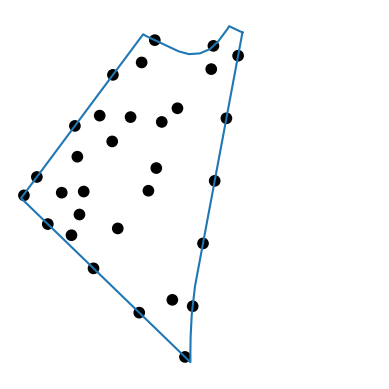

In [9]:
printTurbinesInBoundary(bndry_x_clsd, bndry_y_clsd, turbine_x, turbine_y, turb_min_space/2, region, false)

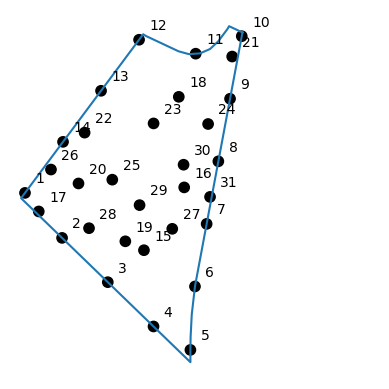

In [15]:
printTurbinesInBoundary(bndry_x_clsd, bndry_y_clsd, turbine_x, turbine_y, turb_min_space/2, region, true)

### Visualize the random starts

In [6]:
function printTurbinesInBoundary(bndry_x_clsd, bndry_y_clsd, turbine_x, turbine_y, turb_diam, region=0, turb_tags=false)
    #- Visualizes the farm boundaries and all turbines passed -#
    # Plot the boundary (defaults to all regions, but will do only one if specified)
    if region == 0
        for i in 1:length(bndry_x_clsd)
            plot(bndry_x_clsd[i], bndry_y_clsd[i])
        end
    else
        plot(bndry_x_clsd[region], bndry_y_clsd[region])
    end
    
    # Plot the turbines
    for i = 1:length(turbine_x)
         plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), turb_diam/2.0, fill=true,color="black"))
    #     plt.gcf().gca().add_artist(plt.Circle((test_values_x[i],test_values_y[i]), turb_diam/2.0, fill=true,color="red"))
        if turb_tags
            plt.text(turbine_x[i]+turb_diam,turbine_y[i]+turb_diam, string(i))
        end
    end

    # Formatting
    axis("square")
    axis("off")
    plt.show()
end
#savefig("MulitCircleOff.pdf")

printTurbinesInBoundary (generic function with 3 methods)

#### Make one random start (Boundary var reduction, interior partition method)

In [110]:
#-- Make the random cs4 turbine locations -#
# Number of reigons we're using (cs4 = 5, cs3 = 1)
num_regions = 5
# Initialize our turbine array
num_farm_turbs = floor(getCs34NumTurbs("cs4"))
turbine_x = zeros(Float64, num_farm_turbs)
turbine_y = zeros(Float64, num_farm_turbs)

turbs_per_region = zeros(Int8, nNumRegions)  # Preallocated turbines in each region
num_bndry_verts = zeros(Int8, nNumRegions)
num_bndry_turbs = zeros(Int8, nNumRegions)
for cntr in 1:nNumRegions
    num_bndry_verts[cntr] = length(getCs34VertList(getCs34Name(cntr)))
    turbs_per_region[cntr] = floor(getCs34NumTurbs(getCs34Name(cntr)))
    num_bndry_turbs[cntr] = floor(getCs34NumBndryTurbs(getCs34Name(cntr)))
end

#- Pull all the indicies -#
bndry_corner_indcies = getCs34VertList("All")

#-- Loop through and do all regions --#
prev_turb_index = 1
bndry_vert_index = 1
for cntr in 1:num_regions
    next_turb_index = ((turbs_per_region[cntr]-1) + prev_turb_index)  # Next index for our Turbines
    #- Parse out the verticies we want -#
    bndry_verts_index = sum(num_bndry_verts[1:cntr]) - num_bndry_verts[cntr] + 1
    bndry_crnr_indx = bndry_corner_indcies[bndry_verts_index:(bndry_verts_index+num_bndry_verts[cntr]-1)]
    # Randomly place the turbines within each boundary
    turbine_x[prev_turb_index:next_turb_index], turbine_y[prev_turb_index:next_turb_index], ~ = iea37cs4SplinedRandoStartsVRBndry(bndry_x_clsd[cntr], bndry_y_clsd[cntr], bndry_crnr_indx, turb_min_space, num_bndry_turbs[cntr], turbs_per_region[cntr])
    prev_turb_index += turbs_per_region[cntr]
end

### Save the Random Starts into `.yaml` files

In [1]:
printTurbinesInBoundary(bndry_x_clsd, bndry_y_clsd, turbine_x, turbine_y, turb_min_space/2)

UndefVarError: UndefVarError: turb_min_space not defined

In [112]:
#-- Save our optimized locations --#
#- Make sure the file doesn't exit -#
directory = "./inputfiles/ieea37cs4-rndstrts/"
file_name = "iea37-cs4-rndstrt-bvr-ipm"
file_type = "yaml"
save_filename = getNextFileName(directory, file_name, file_type)

# Necessary variables for writing turb locations
t = "IEA Wind Task 37 case study 4, BYU's BVR/IPM random start layout"
td = "random start layout for the 81 turbine wind plant model for IEA Task 37 case study 4"
tf ="iea37-10mw.yaml"
lu ="m"
wmu ="iea37-aepcalc.jl"
wrf ="iea37-windrose-cs4.yaml"
x = [copy(turbine_x);copy(turbine_y)]
aepd = aep_wrapper(x, params)
aept = sum(aepd)
aepu ="MWh"
by="./inputfiles/default.yaml"
# Actually write the file
write_turb_loc_YAML(save_filename, turbine_x, turbine_y; title=t, titledescription=td, 
    turbinefile=tf, locunits=lu, wakemodelused=wmu, windresourcefile=wrf, aeptotal=aept, 
    aepdirs=aepd, aepunits=aepu, baseyaml=by)

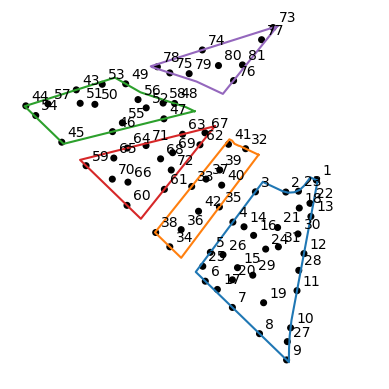

In [115]:
#- Read the turbines from our just saved file (as a test) -#
test_x, test_y, ~, ~ = get_turb_loc_YAML(save_filename)
printTurbinesInBoundary(bndry_x_clsd, bndry_y_clsd, test_x, test_y, turb_min_space/2)


#### Make 100 random start (Boundary var reduction, interior partition method)

In [116]:
#-- Make 100 random start locations with Boundary VarRed, Interior PartMeth -#
num_farm_turbs = floor(getCs34NumTurbs("cs4"))
num_rando_starts = 100

for rando_start in 1:num_rando_starts
    # Initialize our turbine array
    turbine_x = zeros(Float64, num_farm_turbs)
    turbine_y = zeros(Float64, num_farm_turbs)
    
    #-- Loop through and do all regions --#
    prev_turb_index = 1
    bndry_vert_index = 1
    for cntr in 1:num_regions
        next_turb_index = ((turbs_per_region[cntr]-1) + prev_turb_index)  # Next index for our Turbines
        #- Parse out the verticies we want -#
        bndry_verts_index = sum(num_bndry_verts[1:cntr]) - num_bndry_verts[cntr] + 1
        bndry_crnr_indx = bndry_corner_indcies[bndry_verts_index:(bndry_verts_index+num_bndry_verts[cntr]-1)]
        # Randomly place the turbines within each boundary
        turbine_x[prev_turb_index:next_turb_index], turbine_y[prev_turb_index:next_turb_index], ~ = iea37cs4SplinedRandoStartsVRBndry(bndry_x_clsd[cntr], bndry_y_clsd[cntr], bndry_crnr_indx, turb_min_space, num_bndry_turbs[cntr], turbs_per_region[cntr])
        prev_turb_index += turbs_per_region[cntr]
    end

    #- Make sure the file doesn't exit -#
    directory = "./inputfiles/iea37cs4-rndstrts/"
    file_name = "iea37cs4-rndstrt-bvr-ipm"
    file_type = "yaml"
    save_filename = getNextFileName(directory, file_name, file_type)
    # Calculate the correct AEP
    x = [copy(turbine_x);copy(turbine_y)]
    aepd = aep_wrapper(x, params)
    aept = sum(aepd)
    # Write the file
#    write_turb_loc_YAML(save_filename, turbine_x, turbine_y; title=t, titledescription=td, 
#        turbinefile=tf, locunits=lu, wakemodelused=wmu, windresourcefile=wrf, aeptotal=aept, 
#        aepdirs=aepd, aepunits=aepu, baseyaml=by)
end

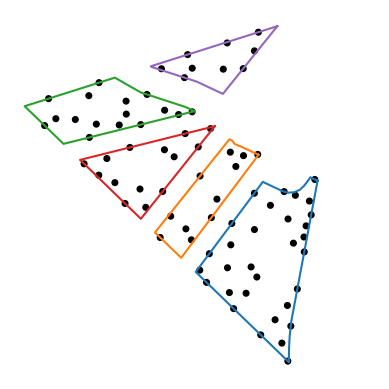

In [127]:
#- Read the turbines from our just saved file (as a test) -#
save_filename = "./inputfiles/iea37cs4-rndstrts/iea37cs4-rndstrt-bvr-ipm-(100).yaml"
test_x, test_y, ~, ~ = get_turb_loc_YAML(save_filename)
printTurbinesInBoundary(bndry_x_clsd, bndry_y_clsd, test_x, test_y, turb_min_space/2)
savefig("./results/iea37cs4-randostart-bvr-ipm.pdf")

While I messed up on one of the .yaml inputs, I otherwise completed what I set out to do. I might re-run this with the error corrected since it's pretty quick to populate, but otherwise, this notebook is complete.